In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import attention_conv.model as modelsrc
# import unet.model as modelsrc
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os
import imp

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
imp.reload(modelsrc)
ModelToTest = modelsrc.AttentionConv
params = []

Setup dataset and dataloader

In [17]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)

Training Setup

In [4]:
BATCH_LEN = 4 #still depends on its_til_update for true loss batch size
EPOCHS = 20

In [5]:
cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

NameError: name 'dataset' is not defined

In [6]:
model = ModelToTest()

Training utilities
# wow

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

NameError: name 'model' is not defined

Training loop definition

In [5]:
dir_to_save = 'conv_concept_models'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [6]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list):
    its_til_checkpoint = 20
    its_til_update = 4
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))
            name_list.append(file_name)

            running_loss = 0
            count = 0
            
        if i == 120: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [21]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

NameError: name 'cl_loader' is not defined

In [7]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    name_list = []
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list)
        print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
        plt.plot(epoch_losses, 'r-')
        plt.title('Epoch Losses')
        plt.show()
        
        #remove old entries
        for name in name_list[:-5]:
            os.remove(os.path.join(dir_to_save, name))
        name_list = name_list[:-5]
    
    return losses

In [8]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

In [9]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = ModelToTest()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
msssim = MS_SSIMLoss(channels=24)
l1 = torch.nn.L1Loss()
criterion = lambda pred, target: msssim(pred,target) #+ l1(pred,target) 

In [ ]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

Entering epoch 0
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4


#### Lets see the results


tensor([[512.4474, 508.4951, 501.8247,  ..., 509.1727, 511.6893, 515.3061],
        [521.2349, 506.9940, 513.7083,  ..., 507.4603, 508.1481, 510.7563],
        [501.3823, 512.2870, 519.7847,  ..., 508.2018, 512.1481, 514.7401],
        ...,
        [515.5525, 512.7459, 515.3796,  ..., 513.4868, 505.4822, 520.0916],
        [517.3005, 507.6083, 507.9785,  ..., 509.1880, 509.6176, 517.5778],
        [505.6002, 515.1064, 514.3691,  ..., 508.8806, 506.1005, 519.1243]])
tensor([[513.5054, 508.7912, 501.3735,  ..., 510.3969, 511.8522, 514.9108],
        [520.0626, 506.9482, 514.0764,  ..., 507.5480, 508.4664, 509.6038],
        [502.1488, 512.0263, 520.8453,  ..., 509.0815, 511.5767, 514.9370],
        ...,
        [515.6843, 512.7280, 516.4143,  ..., 514.7671, 506.0238, 520.1106],
        [517.2912, 506.6956, 507.9821,  ..., 508.2972, 508.8119, 518.2108],
        [506.1801, 515.0936, 515.4159,  ..., 509.2159, 506.4763, 519.2773]])
tensor([[514.1989, 509.6174, 500.8361,  ..., 511.0833, 512.2

tensor([[512.4474, 508.4951, 501.8247,  ..., 509.1728, 511.6893, 515.3061],
        [521.2349, 506.9940, 513.7083,  ..., 507.4603, 508.1481, 510.7563],
        [501.3823, 512.2870, 519.7847,  ..., 508.2018, 512.1481, 514.7401],
        ...,
        [515.5525, 512.7459, 515.3796,  ..., 513.4868, 505.4822, 520.0916],
        [517.3004, 507.6083, 507.9785,  ..., 509.1880, 509.6176, 517.5778],
        [505.6002, 515.1064, 514.3692,  ..., 508.8806, 506.1005, 519.1243]])
tensor([[513.5053, 508.7913, 501.3735,  ..., 510.3969, 511.8522, 514.9108],
        [520.0626, 506.9482, 514.0764,  ..., 507.5480, 508.4664, 509.6039],
        [502.1488, 512.0263, 520.8453,  ..., 509.0815, 511.5767, 514.9370],
        ...,
        [515.6843, 512.7280, 516.4143,  ..., 514.7671, 506.0238, 520.1106],
        [517.2911, 506.6955, 507.9821,  ..., 508.2972, 508.8119, 518.2108],
        [506.1801, 515.0936, 515.4159,  ..., 509.2159, 506.4763, 519.2773]])
tensor([[514.1989, 509.6175, 500.8361,  ..., 511.0833, 512.2

tensor([[512.4474, 508.4951, 501.8247,  ..., 509.1728, 511.6893, 515.3061],
        [521.2349, 506.9940, 513.7083,  ..., 507.4603, 508.1481, 510.7563],
        [501.3823, 512.2870, 519.7847,  ..., 508.2018, 512.1481, 514.7401],
        ...,
        [515.5525, 512.7459, 515.3796,  ..., 513.4868, 505.4822, 520.0916],
        [517.3004, 507.6083, 507.9785,  ..., 509.1880, 509.6176, 517.5778],
        [505.6002, 515.1064, 514.3691,  ..., 508.8806, 506.1005, 519.1243]])
tensor([[513.5053, 508.7912, 501.3735,  ..., 510.3969, 511.8522, 514.9108],
        [520.0626, 506.9482, 514.0764,  ..., 507.5480, 508.4664, 509.6038],
        [502.1488, 512.0263, 520.8453,  ..., 509.0815, 511.5767, 514.9370],
        ...,
        [515.6843, 512.7280, 516.4143,  ..., 514.7671, 506.0238, 520.1106],
        [517.2912, 506.6955, 507.9821,  ..., 508.2972, 508.8119, 518.2108],
        [506.1801, 515.0936, 515.4159,  ..., 509.2159, 506.4763, 519.2773]])
tensor([[514.1989, 509.6175, 500.8361,  ..., 511.0833, 512.2

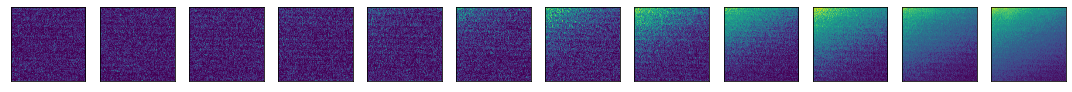

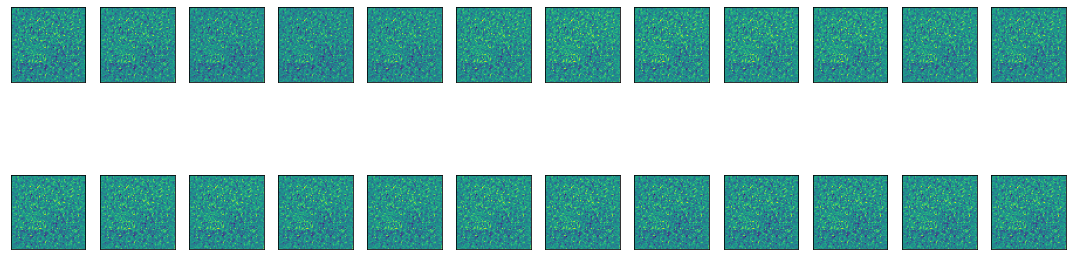

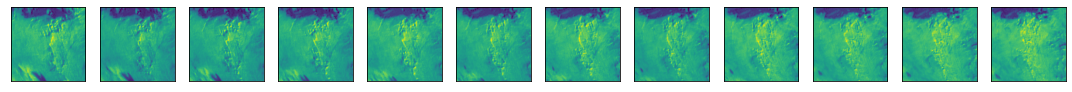

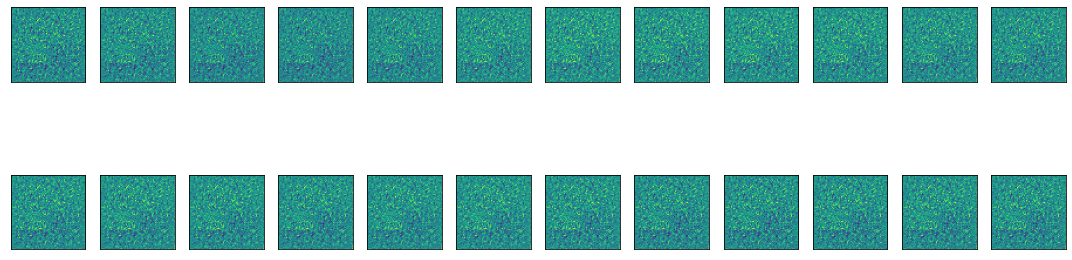

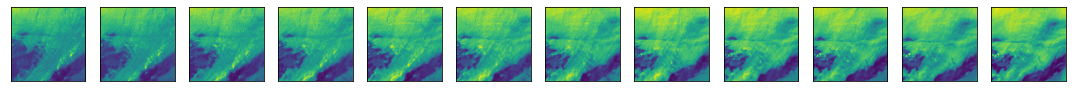

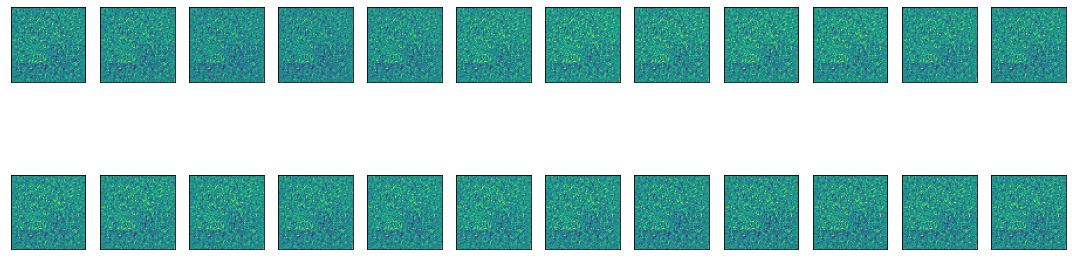

In [13]:
model.eval()
garbo = [dataset[i] for i in range(10, 13)]
for i, (features, targets) in enumerate(garbo):
    if i == 3:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            print(predictions[p_no])
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [10]:
model.load_state_dict(torch.load(os.path.join(dir_to_save, 'epoch-0_iteration-79_loss-0.20146409869194032')))

<All keys matched successfully>

In [17]:
garbo = model.transformer.in_pe.expand(5, -1, -1)
garbo.device

device(type='cuda', index=0)

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()